In [45]:
using DCAUtils, JLD2, Statistics, CSV, DataFrames, PyPlot

In [46]:
function single_mut_dE(seq::Array{Int8, 1}, h::Array{T,2}, J::Array{T,4}, new_aa, mut_pos::Int, L::Int) where {T}
    delta_E = h[seq[mut_pos], mut_pos] - h[new_aa, mut_pos]
    @inbounds for j in 1:L
        delta_E += J[seq[mut_pos], mut_pos, seq[j], j] - J[new_aa, mut_pos, seq[j], j]
    end
    return delta_E
end

let alphabet = [ 1, 21, 2, 3, 4, 5, 6, 7, 8, 21, 9, 10, 11, 12, 21, 13, 14, 15, 16, 17, 21, 18, 19, 21, 20]
               # A, B,  C, D, E, F, G, H, I, J,  K, L,  M,  N,  O,  P,  Q,  R,  S,  T,  U,  V,  W,  X,  Y
    global letter2num
    function letter2num(c::Union{Char,UInt8})
        i = UInt8(c) - 0x40
        1 <= i <= 25 && return alphabet[i]
        return 21
     end
end


let alphabet = ["A", "C", "D", "E", "F", "G", "H", "I",  "K", "L",  "M",  "N", "P",  "Q",  "R",
"S",  "T", "V",  "W",  "Y"]
    global num2letter
    function num2letter(i :: Integer)
        1 <= i <= 20 && return alphabet[i]
        return "-"
    end
end


function extract_1wt(input_df, prot)
    wt = []
    df = input_df[input_df[:, "PROT"] .== prot,:]
    site_vec = df.SITE
    l = length(site_vec)
    for (i, s) in enumerate(site_vec[1:(l - 1)])
        if site_vec[i+1] != site_vec[i] || i == (l - 1)
            append!(wt, df.WTAA[i])
        end
    end
    res = []
    for i in 1:length(wt)
        push!(res, Int8.(letter2num(wt[i])))
    end
    return res
end


extract_1wt (generic function with 1 method)

In [47]:
@load "../../data_SparseHop/dbd_incomplete_model.jld2" J h

L_prot = size(h,2);

In [48]:
df = CSV.read("../../Gen.jl/data/alignments/refs/Thornton.csv", DataFrame)
L = -2.1482 # lower bound of measurement
R =  1.6081 # dynamic range of measurement
U = L + R # upper bound of measurement
WT_ACTIVITY = -0.79 # standard WT activity
LB = L - WT_ACTIVITY + 0.05
UB = U - WT_ACTIVITY - 0.05

df[:,5] = df[:,5] .- WT_ACTIVITY
sel_wt_MAP_1 = [1,    10,    19, 6, 7, 8, 12] # maximum a posteriori reconstructed wt
sel_wt_MAP_2 = [1, 10,    4, 14];

In [49]:
l2n = [num2letter(i) for i in 1:20]
wts1 = Int8.(hcat([extract_1wt(df, prot) for prot in sel_wt_MAP_1]...)')

N_wt = length(sel_wt_MAP_1)
exp_dms = []
dca_dms = []
for i in 1:N_wt
    wt_ind = sel_wt_MAP_1[i]
    dms = df[  df[:, "PROT"] .== wt_ind, :]
    N_mut = length(dms[:,1])
    dEs = zeros(N_mut)
    for n in 1:N_mut
        aa = Int8(findfirst(x -> x == dms.MTAA[n], l2n))
        dEs[n] = single_mut_dE(wts1[i,:], h, J, aa, dms.SITE[n], L_prot) 
    end
    push!(exp_dms, dms.FIT...)
    push!(dca_dms, dEs...)
end

mask = dca_dms .!= 0
exp_dms = exp_dms[mask]
dca_dms = dca_dms[mask]
sort_exp = exp_dms[sortperm(exp_dms, rev = true)]
sort_dca = dca_dms[sortperm(dca_dms, rev = false)]

tot_E2F = Dict([sort_dca[i]=>sort_exp[i] for i in 1:length(sort_dca)])
;


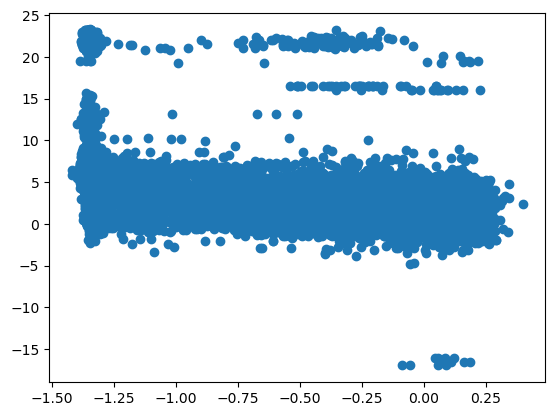

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e487160d0>

In [50]:
plt.plot(exp_dms, dca_dms, "o")

In [52]:
cor(exp_dms, dca_dms)

-0.4570009104382235

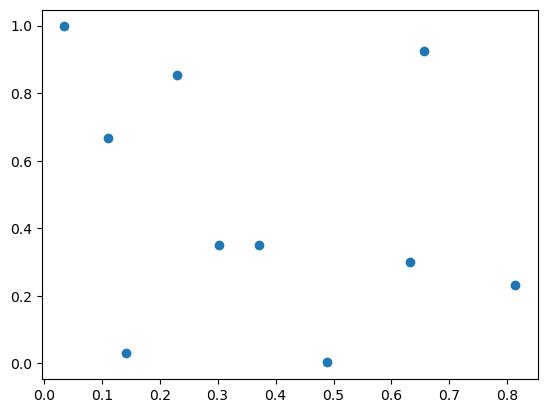

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e48a9a2b0>

In [43]:
plot(rand(10), rand(10), "o")